In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
data = pd.read_csv('월별공급량및비중all.csv')
print(data)
data["ID"] = pd.date_range("1996-01-01", "2020-12-01", freq="MS")

     YEAR  MONTH  도시가스(톤)_민수용  도시가스(톤)_산업용  Unnamed: 4  Unnamed: 5  Unnamed: 6
0    1996      1       605519        83809      689328     0.87842     0.12158
1    1996      2       566323        70427      636750     0.88940     0.11060
2    1996      3       477514        62652      540166     0.88401     0.11599
3    1996      4       337794        47050      384844     0.87774     0.12226
4    1996      5       184522        30709      215231     0.85732     0.14268
..    ...    ...          ...          ...         ...         ...         ...
295  2020      8       398661       457970      856631     0.46538     0.53462
296  2020      9       380235       525619      905853     0.41975     0.58025
297  2020     10       616682       600890     1217571     0.50649     0.49352
298  2020     11      1093747       665901     1759648     0.62157     0.37843
299  2020     12      1921404       811928     2733332     0.70295     0.29705

[300 rows x 7 columns]


In [4]:
civil = data[['YEAR', 'MONTH', "도시가스(톤)_산업용"]]
civil.index = data["ID"]
print(civil.head())

            YEAR  MONTH  도시가스(톤)_산업용
ID                                  
1996-01-01  1996      1        83809
1996-02-01  1996      2        70427
1996-03-01  1996      3        62652
1996-04-01  1996      4        47050
1996-05-01  1996      5        30709


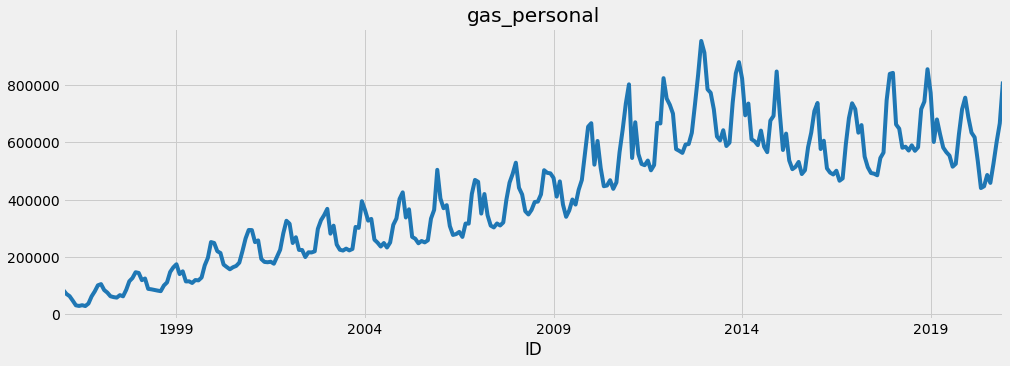

In [5]:
civil['도시가스(톤)_산업용'].plot(style='-',
          figsize=(15, 5),
          color=color_pal[0],
          title='gas_personal')

plt.show()

In [6]:
split_date = '2017-12-01'
train = civil.loc[civil.index <= split_date].copy()
test = civil.loc[civil.index > split_date].copy()

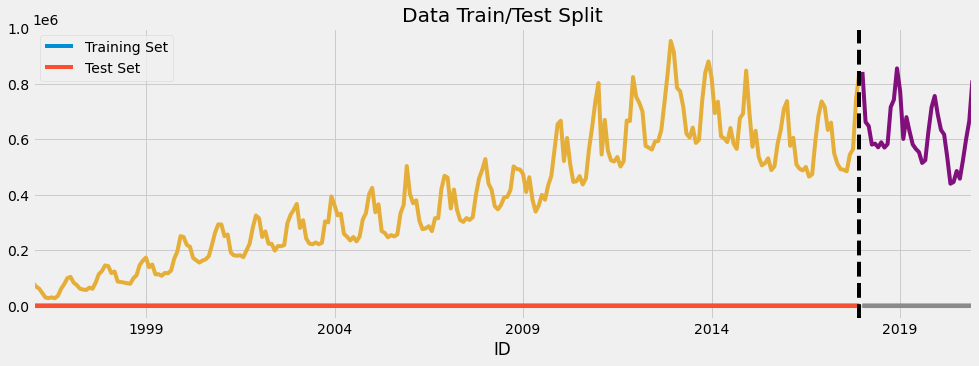

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
civil = civil.sort_index()

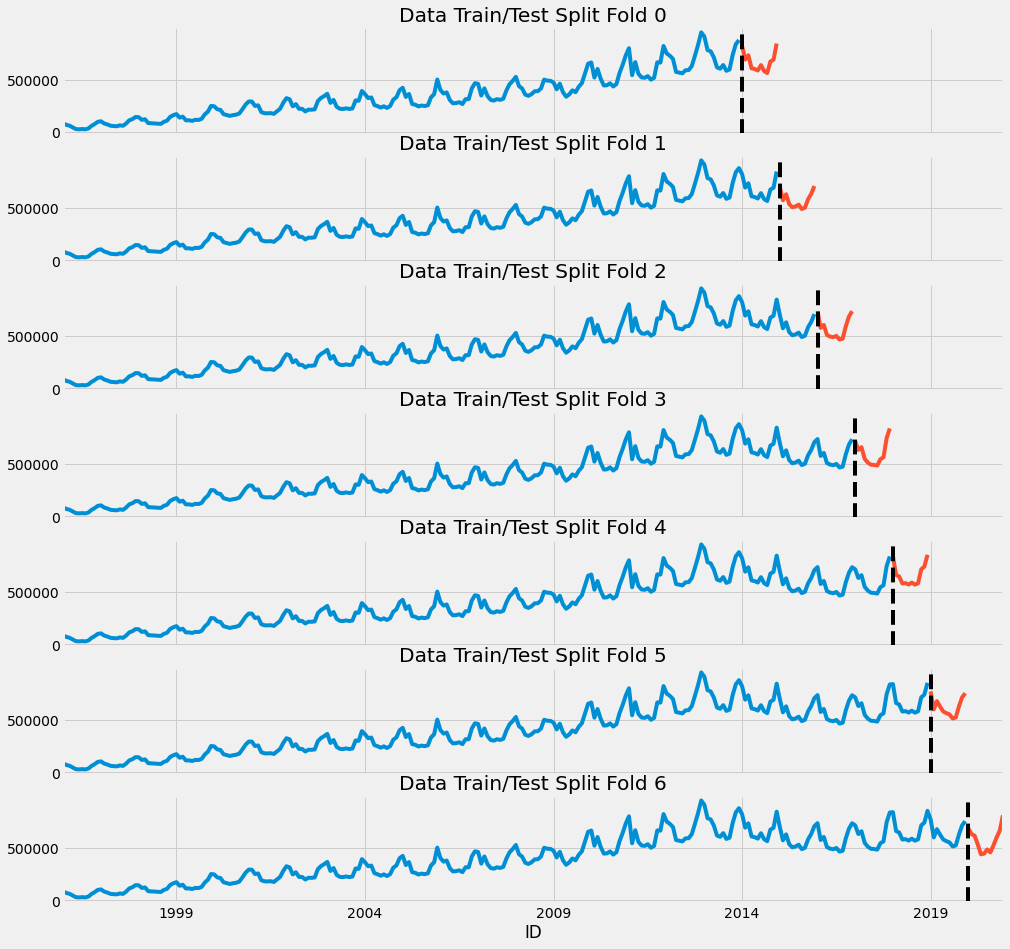

In [9]:
fig, axs = plt.subplots(7, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(civil):
    train = civil.iloc[train_idx]
    test = civil.iloc[val_idx]
    train['도시가스(톤)_산업용'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['도시가스(톤)_산업용'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [10]:
def add_lags(df):
    df['lag1'] = df['도시가스(톤)_산업용'].shift(12)
    df['lag2'] = df['도시가스(톤)_산업용'].shift(24)
    return df

In [11]:
civil = add_lags(civil)

In [12]:
tss = TimeSeriesSplit(n_splits=7, test_size=12, gap=0)
civil = civil.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(civil):
    train = civil.iloc[train_idx]
    test = civil.iloc[val_idx]

    FEATURES = ['MONTH', 'lag1','lag2']
    TARGET = '도시가스(톤)_산업용'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                           booster='gbtree',    
                           n_estimators=250,
                           objective='reg:squarederror',
                           max_depth=3,
                           eval_metric='mae',
                           learning_rate=0.01
                          )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-mae:337826.84375	validation_1-mae:664578.75000
[100]	validation_0-mae:127965.33594	validation_1-mae:218777.95312
[200]	validation_0-mae:49625.93359	validation_1-mae:46515.35938
[249]	validation_0-mae:33239.59375	validation_1-mae:48120.77734
[0]	validation_0-mae:355038.37500	validation_1-mae:568696.43750
[100]	validation_0-mae:134095.65625	validation_1-mae:141091.98438
[200]	validation_0-mae:51971.76172	validation_1-mae:46811.50000
[249]	validation_0-mae:35373.82031	validation_1-mae:75325.39844
[0]	validation_0-mae:365775.93750	validation_1-mae:565220.81250
[100]	validation_0-mae:137763.54688	validation_1-mae:190822.75000
[200]	validation_0-mae:53451.91406	validation_1-mae:77694.96875
[249]	validation_0-mae:36890.98438	validation_1-mae:70781.07031
[0]	validation_0-mae:375310.40625	validation_1-mae:597001.18750
[100]	validation_0-mae:141048.85938	validation_1-mae:225523.20312
[200]	validation_0-mae:54469.92188	validation_1-mae:80462.83594
[249]	validation_0-mae:37350.191

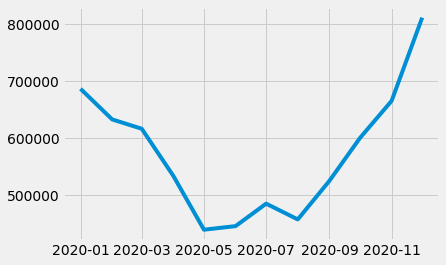

In [13]:
plt.plot(y_test)

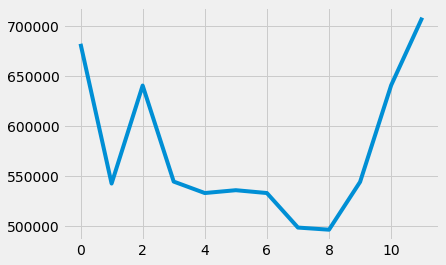

In [14]:
plt.plot(y_pred)

In [15]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 74464.4050
Fold scores:[56908.86267806512, 89645.88694719074, 85261.0804285853, 74669.3228836253, 106686.05335649468, 46826.2607623131, 61253.36825902129]


In [16]:
FEATURES = ['MONTH', 'lag1','lag2']
TARGET = '도시가스(톤)_산업용'

X_all = civil[FEATURES]
y_all = civil[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=460,
                       objective='reg:squarederror',
                       max_depth=3,
                       eval_metric='mae',
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-mae:412936.43750
[100]	validation_0-mae:154484.79688
[200]	validation_0-mae:59719.29297
[300]	validation_0-mae:32555.59570
[400]	validation_0-mae:25978.77930
[459]	validation_0-mae:24551.61719


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='mae', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=460, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
civil.index.max()

Timestamp('2020-12-01 00:00:00')

In [18]:
future = pd.date_range('2021-01-01','2021-12-01', freq='MS')
future_civil = pd.DataFrame(index=future)
future_civil['MONTH'] = future.month
future_civil['isFuture'] = True
civil['isFuture'] = False
civil_and_future = pd.concat([civil, future_civil])
civil_and_future = add_lags(civil_and_future)
print(civil_and_future)

              YEAR  MONTH  도시가스(톤)_산업용      lag1      lag2  isFuture
1996-01-01  1996.0      1      83809.0       NaN       NaN     False
1996-02-01  1996.0      2      70427.0       NaN       NaN     False
1996-03-01  1996.0      3      62652.0       NaN       NaN     False
1996-04-01  1996.0      4      47050.0       NaN       NaN     False
1996-05-01  1996.0      5      30709.0       NaN       NaN     False
...            ...    ...          ...       ...       ...       ...
2021-08-01     NaN      8          NaN  457970.0  514526.0      True
2021-09-01     NaN      9          NaN  525619.0  524795.0      True
2021-10-01     NaN     10          NaN  600890.0  628223.0      True
2021-11-01     NaN     11          NaN  665901.0  714870.0      True
2021-12-01     NaN     12          NaN  811928.0  755546.0      True

[312 rows x 6 columns]


In [19]:
future_w_features = civil_and_future.query('isFuture').copy()
print(future_w_features)

            YEAR  MONTH  도시가스(톤)_산업용      lag1      lag2  isFuture
2021-01-01   NaN      1          NaN  687084.0  772539.0      True
2021-02-01   NaN      2          NaN  633396.0  600861.0      True
2021-03-01   NaN      3          NaN  616998.0  679395.0      True
2021-04-01   NaN      4          NaN  534319.0  627743.0      True
2021-05-01   NaN      5          NaN  439949.0  581306.0      True
2021-06-01   NaN      6          NaN  446235.0  565142.0      True
2021-07-01   NaN      7          NaN  485652.0  553295.0      True
2021-08-01   NaN      8          NaN  457970.0  514526.0      True
2021-09-01   NaN      9          NaN  525619.0  524795.0      True
2021-10-01   NaN     10          NaN  600890.0  628223.0      True
2021-11-01   NaN     11          NaN  665901.0  714870.0      True
2021-12-01   NaN     12          NaN  811928.0  755546.0      True


In [20]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [21]:
#print(future_w_features['pred'])
#print(future_w_features.index)
civil_and_future.loc[future_w_features.index, '도시가스(톤)_산업용']=future_w_features['pred']
civil_and_future['isFuture'] = False
print(civil_and_future)

              YEAR  MONTH  도시가스(톤)_산업용      lag1      lag2  isFuture
1996-01-01  1996.0      1    83809.000       NaN       NaN     False
1996-02-01  1996.0      2    70427.000       NaN       NaN     False
1996-03-01  1996.0      3    62652.000       NaN       NaN     False
1996-04-01  1996.0      4    47050.000       NaN       NaN     False
1996-05-01  1996.0      5    30709.000       NaN       NaN     False
...            ...    ...          ...       ...       ...       ...
2021-08-01     NaN      8   530950.750  457970.0  514526.0     False
2021-09-01     NaN      9   554031.125  525619.0  524795.0     False
2021-10-01     NaN     10   574794.250  600890.0  628223.0     False
2021-11-01     NaN     11   706419.500  665901.0  714870.0     False
2021-12-01     NaN     12   808546.250  811928.0  755546.0     False

[312 rows x 6 columns]


In [22]:
def hyun_pred(start, finish):
    global civil_and_future
    future = pd.date_range(start, finish, freq='MS')
    future_civil = pd.DataFrame(index=future)
    future_civil['MONTH'] = future.month
    future_civil['isFuture'] = True
    civil_and_future = pd.concat([civil_and_future, future_civil])
    civil_and_future = add_lags(civil_and_future)

    future_w_features = civil_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    civil_and_future.loc[future_w_features.index, '도시가스(톤)_산업용']=future_w_features['pred']
    civil_and_future['isFuture'] = False

    return civil_and_future

In [23]:
for i in pd.date_range('2022-01-01', '2035-01-01',freq='AS'):
    for j in pd.date_range(i, periods=12, freq='MS'):
        continue
    civil_and_future = hyun_pred(i, j)
    print(civil_and_future.head())
    print(civil_and_future.tail())

              YEAR  MONTH  도시가스(톤)_산업용  lag1  lag2  isFuture
1996-01-01  1996.0      1      83809.0   NaN   NaN     False
1996-02-01  1996.0      2      70427.0   NaN   NaN     False
1996-03-01  1996.0      3      62652.0   NaN   NaN     False
1996-04-01  1996.0      4      47050.0   NaN   NaN     False
1996-05-01  1996.0      5      30709.0   NaN   NaN     False
            YEAR  MONTH  도시가스(톤)_산업용        lag1      lag2  isFuture
2022-08-01   NaN      8  541896.6875  530950.750  457970.0     False
2022-09-01   NaN      9  582991.0000  554031.125  525619.0     False
2022-10-01   NaN     10  577250.2500  574794.250  600890.0     False
2022-11-01   NaN     11  706419.5000  706419.500  665901.0     False
2022-12-01   NaN     12  808546.2500  808546.250  811928.0     False
              YEAR  MONTH  도시가스(톤)_산업용  lag1  lag2  isFuture
1996-01-01  1996.0      1      83809.0   NaN   NaN     False
1996-02-01  1996.0      2      70427.0   NaN   NaN     False
1996-03-01  1996.0      3      62652.

              YEAR  MONTH  도시가스(톤)_산업용  lag1  lag2  isFuture
1996-01-01  1996.0      1      83809.0   NaN   NaN     False
1996-02-01  1996.0      2      70427.0   NaN   NaN     False
1996-03-01  1996.0      3      62652.0   NaN   NaN     False
1996-04-01  1996.0      4      47050.0   NaN   NaN     False
1996-05-01  1996.0      5      30709.0   NaN   NaN     False
            YEAR  MONTH  도시가스(톤)_산업용         lag1         lag2  isFuture
2035-08-01   NaN      8   582991.000  544364.3125  549317.2500     False
2035-09-01   NaN      9   580808.250  582991.0000  544364.3125     False
2035-10-01   NaN     10   573106.875  573106.8750  569345.9375     False
2035-11-01   NaN     11   706419.500  706419.5000  706419.5000     False
2035-12-01   NaN     12   808546.250  808546.2500  808546.2500     False


In [24]:
print(civil_and_future.head())

              YEAR  MONTH  도시가스(톤)_산업용  lag1  lag2  isFuture
1996-01-01  1996.0      1      83809.0   NaN   NaN     False
1996-02-01  1996.0      2      70427.0   NaN   NaN     False
1996-03-01  1996.0      3      62652.0   NaN   NaN     False
1996-04-01  1996.0      4      47050.0   NaN   NaN     False
1996-05-01  1996.0      5      30709.0   NaN   NaN     False


              YEAR  MONTH  도시가스(톤)_산업용      lag1      lag2  isFuture
1996-01-01  1996.0      1      83809.0       NaN       NaN     False
1996-02-01  1996.0      2      70427.0       NaN       NaN     False
1996-03-01  1996.0      3      62652.0       NaN       NaN     False
1996-04-01  1996.0      4      47050.0       NaN       NaN     False
1996-05-01  1996.0      5      30709.0       NaN       NaN     False
...            ...    ...          ...       ...       ...       ...
2001-08-01  2001.0      8     175939.0  168129.0  117823.0     False
2001-09-01  2001.0      9     200150.0  179575.0  127849.0     False
2001-10-01  2001.0     10     224570.0  219854.0  170198.0     False
2001-11-01  2001.0     11     281975.0  264161.0  196487.0     False
2001-12-01  2001.0     12     325748.0  293726.0  251488.0     False

[72 rows x 6 columns]


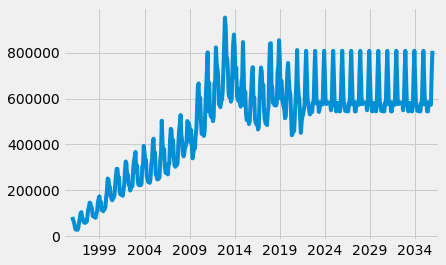

In [25]:
print(civil_and_future.head(72))
civil_and_future['도시가스(톤)_산업용'].plot(xlim=[300,800])
plt.show()